<a href="https://colab.research.google.com/github/abenfaddoul/Image-Classification-in-E-Commerce/blob/main/Vision_Transformers_for_Image_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Image Classification in E-Commerce:**

```
*Vision Transformers for Image Classification*
We will work with the PyTorch library to build and train a vision transformer specifically for image classification tasks
```




Setup
For this lab, we will be using the following libraries:

**numpy** for mathematical and array operations.

**sklearn** for machine learning and machine-learning-pipeline related functions.

**torchvision** for deep learning and neural network-related functions.

**torch** for multi-dimensional tensors and mathematical operations over tensors.

**matplotlib** for additional plotting tools.

**PIL** for loading images.

### All Libraries required for this lab are listed below.
## #!pip install -qy pandas==1.3.4 numpy==1.21.4 seaborn==0.9.0 matplotlib==3.5.0 scikit-learn==0.20.1





In [16]:
pip install skillsnetwork

In [17]:
import os
from PIL import Image
import numpy as np
import skillsnetwork
## Imports for plotting
import matplotlib.pyplot as plt
import torch
import torchvision
from torchvision.datasets import CIFAR10
from torchvision import transforms
from torchvision.utils import make_grid
import torch.nn as nn
from torchvision import transforms
from matplotlib.pyplot import figure
from sklearn.manifold import TSNE
from tqdm import tqdm

import torch.optim as optim
import torch.nn.functional as F
from torch.optim.lr_scheduler import ExponentialLR

### Defining Helper Functions

In [18]:
def plot_samples(dataset, size_even=6, classes=None):

    size_even = 6  # Default number of samples to plot
    dataset = train_set  # Default dataset to use (assuming 'train_set')
    fig, axs = plt.subplots(2, int(size_even // 2))  # Create subplots for the samples

    if classes is None:
        classes = tuple([n for n in range(len(dataset))])  # Default class labels

    n_samples = len(dataset)  # Total number of samples in the dataset

    # Randomly select samples
    samples = np.random.randint(0, high=n_samples - 1, size=int(size_even))

    row = 0
    col = 0
    for n, sample in enumerate(samples):
        img = dataset[sample][0]  # Get the image from the dataset
        label = "y={}".format(classes[int(dataset[sample][1])])  # Get the label for the image

        col = n

        # Determine the row and column index for the current sample
        if n > size_even / 2 - 1:
            row = 1
            col = n - int(size_even / 2)

        # Display the image and label in the corresponding subplot
        axs[row, col].imshow(make_grid(img, normalize=True).permute(1, 2, 0))
        axs[row, col].set_title(label)
        axs[row, col].axis('off')

In [19]:
def plot_image_patchs(patchs, seq=False):

    if patchs.shape[-3] == 1:
        patchs = patchs.repeat(1, 1, 3, 1, 1)  # Add 3 channel dimension if image is grayscale

    N_patchs = patchs.shape[1]  # Number of image patches

    plot_patchs = make_grid(patchs, normalize=True).permute(0, 2, 3, 1)  # Arrange patches for plotting

    N_rows = int(np.sqrt(N_patchs))  # Number of rows for the grid plot

    # Create subplots for the image patches
    if seq:
        fig, ax = plt.subplots(1, N_rows * N_rows, sharex='col', sharey='row', figsize=(25, 5))
        fig.suptitle("Image as Sequence")
    else:
        fig, ax = plt.subplots(N_rows, N_rows, sharex='col', sharey='row')
        fig.suptitle("Image")

    i, j = 0, 0
    for n in range(N_patchs):
        if seq:
            ax[n].imshow(plot_patchs[n])
            ax[n].set_xlabel(str(n + 1))
            ax[n].axes.xaxis.set_ticklabels([])
            ax[n].axes.yaxis.set_ticklabels([])
        else:
            if n % N_rows == 0 and n != 0:
                i += 1
                j = 0

            ax[i, j].imshow(plot_patchs[n])
            ax[i, j].set_ylabel(str(n + 1))
            ax[i, j].axes.xaxis.set_ticklabels([])
            ax[i, j].axes.yaxis.set_ticklabels([])
            j += 1

    plt.show()


In [20]:
def plot_patchs_lables(X, y, label=True, p_show=0.5):
    '''
    The code implements a function for plotting t-SNE visualization of patches and their labels, with the option to label each point and control
    the frequency of labeling for the sequence index.

    X: This is a tensor representing the data to be plotted. It should have the shape (sample, patch, dim), where sample is the number of samples, patch is the size of each patch or sequence length, and dim is the number of features for each patch.
    y: This is a tensor representing the labels for each sample. It should have the shape (sample, 1).
    label: This is a boolean value that controls whether to label each data point in the plot. If label is set to True, each data point in the plot will be labeled.
    p_show: This is a float value between 0 and 1 that controls the frequency of labeling for the sequence index. It specifies the probability of showing a label for each data point. For example, if p_show is set to 0.5, then approximately half of the data points will be labeled.
    '''

    # Detach X from its computational graph if it's not a leaf node
    if not (X.is_leaf):
        X = X.detach()

    # Get the shape of the input tensor X
    if X.shape[0] == 49:
        sample = X.shape[1]
        patch = X.shape[0]  # Patch size or sequence length
        dim = X.shape[2]
    if X.shape[0] == 1000:
        sample = X.shape[0]
        patch = X.shape[1]
        dim = X.shape[2]

    # Reshape X and convert it to a numpy array
    X = X.reshape(sample * patch, dim).numpy()

    # Flatten the y tensor and convert it to a numpy array to label each sequence
    colors = y.repeat(patch, 1).T.flatten().numpy()

    # Perform t-SNE on the X data
    X_ = TSNE(n_components=2, learning_rate='auto', init='random').fit_transform(X)

    # Create a scatter plot of the t-SNE transformed X data with each class labeled via color
    fig, ax = plt.subplots()
    for color in np.unique(colors):
        temp = colors == color
        ax.scatter(X_[temp, 0], X_[temp, 1], label=color)

    # If the label argument is set to True, add labels to the scatter plot
    if label:
        for i, x in enumerate(X_):
            # Label plots with a probability of p_show
            if np.random.binomial(1, p_show, 1).item() == 1:
                ax.annotate(str(i % patch), (x[0], x[1]))

    # Add a legend to the scatter plot
    ax.legend()

Convert an image into a set of vectors.

In [21]:
def img_to_patch(x, patch_size, flatten_channels=True):

    B, C, H, W = x.shape
    x = x.reshape(B, C, H//patch_size, patch_size, W//patch_size, patch_size)
    x = x.permute(0, 2, 4, 1, 3, 5) # [B, H', W', C, p_H, p_W]
    x = x.flatten(1,2)              # [B, H'*W', C, p_H, p_W]
    if flatten_channels:
        x = x.flatten(2,4)          # [B, H'*W', C*p_H*p_W]
    return x

Loading MNIST dataset | Normalization

In [22]:
BATCH_SIZE_TRAIN = 100
BATCH_SIZE_TEST = 1000

transform_mnist = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize((0.1307,), (0.3081,))])

train_set = torchvision.datasets.MNIST(root='.',train=True, download=True,
                                       transform=transform_mnist)

test_set = torchvision.datasets.MNIST(root='.',train=False, download=True,
                                      transform=transform_mnist)

DataLoader

In [23]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE_TRAIN, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=BATCH_SIZE_TEST, shuffle=True)

Images as Sequences
The first line creates an iterator **it** from the **test_loader** data loader. The iterator allows us to iterate over the test dataset in batches, enabling us to access and process the data in a sequential manner.

The second line retrieves the next batch of data from the iterator using the **next() function**. By accessing the element at index 0, it retrieves the input images from the batch. In this case, it fetches the input image from the first batch of the test dataset.

In [24]:
it=iter(test_loader)
image=next(it)[0]

image is assumed to be a tensor, and **B, C, H and W**  represent the **batch size, number of channels, height, and width respectively**

In [25]:
B, C, H, W = image.shape
print("batch size: {}, number of channels: {}, height: {},  width: {}".format( B, C, H, W ))

batch size: 1000, number of channels: 1, height: 28,  width: 28


The image itself represents the last two dimensions.


In [26]:
image[0][0].shape

torch.Size([28, 28])

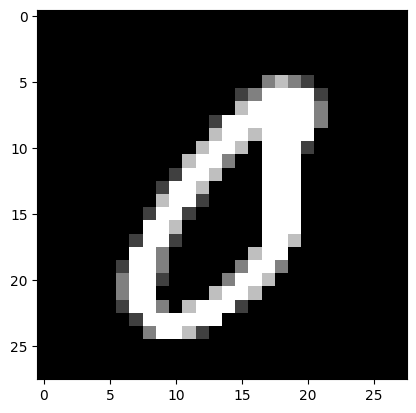

In [27]:
plt.imshow(image[0][0].numpy(),cmap="gray")
plt.show()

To split the image into patches, we will use a patch size of 4. The number of batches can be determined by dividing the size of the image by the patch size and squaring the result, assuming that the patches form a square shape.


In [28]:
patch_size=4

n_patches=(H/patch_size)* (W/patch_size)
n_patches

49.0

We have the option to convert the image into a set of patches. In this case, when **`flatten_channels`** is set to **`False`**, the patches are arranged in an image grid format instead of flattening the channels. This arrangement enables us to visualize the patches as a grid and use them as a feature vector for further analysis or application.


In [29]:
patches=img_to_patch(torch.unsqueeze(test_set[1][0],0), patch_size, flatten_channels=False)

In [30]:
patches.shape

torch.Size([1, 49, 1, 4, 4])

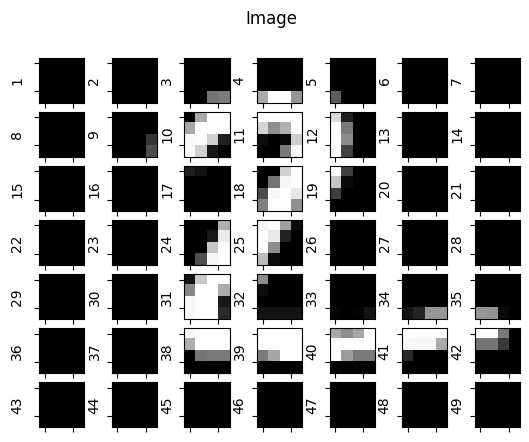

In [31]:
plot_image_patchs(patches)

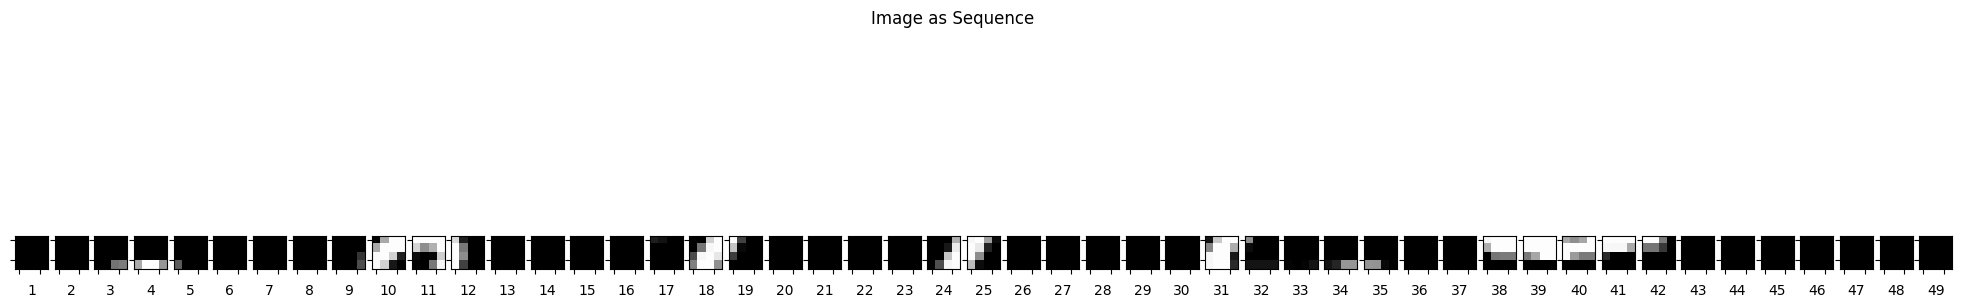

In [32]:
plot_image_patchs(patches, seq=True)

**Constructing Vision Transformer Model**

We will now construct a Transformer model specifically designed for image-related tasks, utilizing the nn.MultiheadAttention module provided by PyTorch.

In [33]:
class AttentionBlock(nn.Module):

    def __init__(self, embed_dim, hidden_dim, num_heads, dropout=0.0):
        """
        Inputs:
            embed_dim - Dimensionality of input and attention feature vectors
            hidden_dim - Dimensionality of hidden layer in feed-forward network
                         (usually 2-4x larger than embed_dim)
            num_heads - Number of heads to use in the Multi-Head Attention block
            dropout - Amount of dropout to apply in the feed-forward network
            #source:https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/tutorial15/Vision_Transformer.html
        """
        super().__init__()

        self.layer_norm_1 = nn.LayerNorm(embed_dim)
        self.attn = nn.MultiheadAttention(embed_dim, num_heads,
                                          dropout=dropout)
        self.layer_norm_2 = nn.LayerNorm(embed_dim)
        self.linear = nn.Sequential(
            nn.Linear(embed_dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, embed_dim),
            nn.Dropout(dropout)
        )


    def forward(self, x):
        inp_x = self.layer_norm_1(x)
        x = x + self.attn(inp_x, inp_x, inp_x)[0]
        x = x + self.linear(self.layer_norm_2(x))
        return x

The VisionTransformer is utilized for image classification and follows a set of steps to process the input image:

1. **Preprocessing**: The img_to_patch function divides the input image into patches.
2. **Input Encoding**: The patches pass through an input layer, generating feature vectors.
3. **Positional Encoding**: The feature vectors incorporate positional embeddings and a CLS token, capturing spatial information.
4. **Transformer Blocks**: Multiple Transformer blocks process the feature vectors and positional embeddings, employing self-attention mechanisms to capture patch dependencies and extract meaningful representations.
5. **Classification Prediction**: The output from the Transformer blocks enters an MLP head, responsible for the final classification prediction.

In [34]:
class VisionTransformer(nn.Module):

    def __init__(self, embed_dim, hidden_dim, num_channels, num_heads, num_layers, num_classes, patch_size, num_patches, dropout=0.0):
        """
        Inputs:
            embed_dim - Dimensionality of the input feature vectors to the Transformer
            hidden_dim - Dimensionality of the hidden layer in the feed-forward networks
                         within the Transformer
            num_channels - Number of channels of the input (3 for RGB)
            num_heads - Number of heads to use in the Multi-Head Attention block
            num_layers - Number of layers to use in the Transformer
            num_classes - Number of classes to predict
            patch_size - Number of pixels that the patches have per dimension
            num_patches - Maximum number of patches an image can have
            dropout - Amount of dropout to apply in the feed-forward network and
                      on the input encoding
             #source:https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/tutorial15/Vision_Transformer.html
        """
        super().__init__()

        self.patch_size = patch_size

        # Layers/Networks
        self.input_layer = nn.Linear(num_channels*(patch_size**2), embed_dim)
        self.transformer = nn.Sequential(*[AttentionBlock(embed_dim, hidden_dim, num_heads, dropout=dropout) for _ in range(num_layers)])
        self.mlp_head = nn.Sequential(
            nn.LayerNorm(embed_dim),
            nn.Linear(embed_dim, num_classes)
        )
        self.dropout = nn.Dropout(dropout)

        # Parameters/Embeddings
        self.cls_token = nn.Parameter(torch.randn(1,1,embed_dim))
        self.pos_embedding = nn.Parameter(torch.randn(1,1+num_patches,embed_dim))
        print(num_patches)


    def forward(self, x):
        # Preprocess input
        x = img_to_patch(x, self.patch_size)
        B, T, _ = x.shape
        x = self.input_layer(x)

        # Add CLS token and positional encoding
        cls_token = self.cls_token.repeat(B, 1, 1)
        x = torch.cat([cls_token, x], dim=1)

        x = x + self.pos_embedding[:,:T+1]

        # Apply Transforrmer
        x = self.dropout(x)
        x = x.transpose(0, 1)
        x = self.transformer(x)

        # Perform classification prediction
        cls = x[0]
        out = self.mlp_head(cls)
        return out

### Train Model

In [35]:
embed_dim= 256
hidden_dim=512
num_heads= 8
num_layers=6
patch_size=4
num_channels=1
num_patches=64
num_classes=10
dropout=0.2
model=VisionTransformer( embed_dim= embed_dim, hidden_dim=hidden_dim, num_channels=num_channels, num_heads=num_heads, num_layers=num_layers, num_classes=num_classes, patch_size=patch_size, num_patches=num_patches, dropout=dropout)

64


In [36]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model.to(device)
device

device(type='cpu')

In [37]:
lr=3e-4
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=lr)
scheduler = ExponentialLR(optimizer, gamma=0.9)

Even 1 epoch for training takes long time. You can skip the training here and import the pre-trained model following the instruction below.

In [38]:
'''
useful_stuff = {'training_loss': [], 'validation_accuracy': []}
correct_old=0

for epoch in tqdm(range(100)):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(train_loader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        model.train()
        outputs = model(inputs)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()

        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0
    scheduler.step()
    useful_stuff['training_loss'].append(running_loss)
    correct = 0
    model.eval()

    for inputs, labels in test_loader:
      inputs, labels = inputs.to(device), labels.to(device)
      z = model(inputs)
      _, yhat = torch.max(z, 1)
      correct += (yhat == labels).sum().item()
      if correct>correct_old:
          correct_old=correct

    useful_stuff['validation_accuracy'].append(correct_old/len(test_set))
print('Finished Training')
'''

"\nuseful_stuff = {'training_loss': [], 'validation_accuracy': []}\ncorrect_old=0\n\nfor epoch in tqdm(range(100)):  # loop over the dataset multiple times\n\n    running_loss = 0.0\n    for i, data in enumerate(train_loader):\n        # get the inputs; data is a list of [inputs, labels]\n        inputs, labels = data[0].to(device), data[1].to(device)\n\n        # zero the parameter gradients\n        optimizer.zero_grad()\n\n        # forward + backward + optimize\n        model.train()\n        outputs = model(inputs)\n\n        loss = criterion(outputs, labels)\n        loss.backward()\n        optimizer.step()\n\n        # print statistics\n        running_loss += loss.item()\n\n        if i % 2000 == 1999:    # print every 2000 mini-batches\n            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')\n            running_loss = 0.0\n    scheduler.step()\n    useful_stuff['training_loss'].append(running_loss)\n    correct = 0\n    model.eval()\n\n    for inputs,

### Loading Pre-trained model

In [39]:
dataset_url="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMSkillsNetwork-GPXX0CLHEN/gray_5_blocks_v2.pt"
dataset_path = "./gray_5_blocks_v2.pt"
await skillsnetwork.prepare(dataset_url, overwrite=True)

  0%|          | 0/82 [00:00<?, ?it/s]

Saved to '.'


In [40]:
model.load_state_dict(torch.load('gray_5_blocks_v2.pt',map_location=device))
model.eval()

VisionTransformer(
  (input_layer): Linear(in_features=16, out_features=256, bias=True)
  (transformer): Sequential(
    (0): AttentionBlock(
      (layer_norm_1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
      )
      (layer_norm_2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (linear): Sequential(
        (0): Linear(in_features=256, out_features=512, bias=True)
        (1): GELU(approximate='none')
        (2): Dropout(p=0.2, inplace=False)
        (3): Linear(in_features=512, out_features=256, bias=True)
        (4): Dropout(p=0.2, inplace=False)
      )
    )
    (1): AttentionBlock(
      (layer_norm_1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
      )
      (layer_norm_2): Layer

In [41]:
it=iter(test_loader)
images= next(it)

The **<code>activations</code>** list  is used to store the activation values obtained from specific layers of the model. These **<code>activations</code>** are then passed as input to the **<code>plot_patchs_lables()</code>** function for visualization purposes.

In [42]:
number_samples = 100

# Create a random input tensor
input_tensor = images[0:number_samples][0]
input_labels = images[0:number_samples][1]

# Define a list to store the activation values
activations = []

# Define a custom activation hook function
def activation_hook(module, input, output):
    activations.append(output.detach())

In [43]:
# Iterate over all the modules in the network
for module in model.modules():
    # Register the activation hook to the desired layers
    if isinstance(module, nn.Linear):
        module.register_forward_hook(activation_hook)

with torch.no_grad():
    output = model(input_tensor)

**NOTE**: The plotting takes around ~19 minutes per iteration, and there will be 6 iterations. Therefore, I am adding the images I have stored on my local disk. You can skip running the cell below.


In [44]:
'''activation_new = 0
for i, activation in enumerate(activations):
    if activation.shape[-1] == 256:
        if activation.shape[0] != 1:
            activation_new = torch.permute(activation, (1, 0, 2))
        else:
            activation_new = activation

    if i % 5 == 0:
        print(i)
        plot_patchs_lables(activation_new, input_labels, label=True, p_show=0)
        plt.show() '''

'activation_new = 0\nfor i, activation in enumerate(activations):\n    if activation.shape[-1] == 256:\n        if activation.shape[0] != 1:\n            activation_new = torch.permute(activation, (1, 0, 2))\n        else:\n            activation_new = activation\n\n    if i % 5 == 0:\n        print(i)\n        plot_patchs_lables(activation_new, input_labels, label=True, p_show=0)\n        plt.show() '

Again, the iterator is used to get images and labels

In [45]:
it=iter(test_loader)
images, labels= next(it)

## Output for the model

Lets classify the image using the output of the model

#### Softmax
Let's say the model's output raw scores for an input example are the input neural network: $$\text{Raw scores} = [3.2, 2.1, 1.5]$$

To calculate the softmax probabilities, we apply the softmax function to these raw scores:

$$
\text{softmax}([3.2, 2.1, 1.5]) = \left[ \frac{e^{3.2}}{e^{3.2} + e^{2.1} + e^{1.5}}, \frac{e^{2.1}}{e^{3.2} + e^{2.1} + e^{1.5}}, \frac{e^{1.5}}{e^{3.2} + e^{2.1} + e^{1.5}} \right]
$$


Now, let's calculate the softmax values:

$$\text{softmax}([3.2, 2.1, 1.5]) ≈ [0.533, 0.278, 0.189]$$

**In our case, the same principle is applied to the MNIST dataset, where each class from 0 to 9 is assigned a probability value. The label with the highest probability value is selected as the predicted label.**


#### Argmax

The **<code>argmax()</code>** function is a mathematical function that returns the index of the maximum value in a tensor or array along a specified axis. In the context of the code snippet provided, **<code>argmax(dim=1)</code>** is used to find the index of the class with the highest probability for each image.


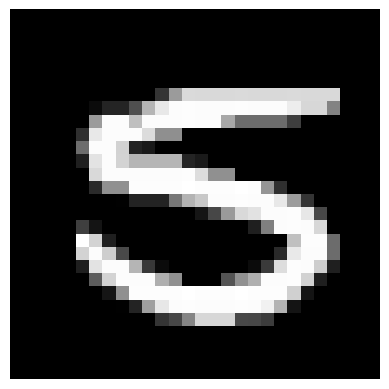

Predicted label: tensor(0)
Actual label: tensor(5)
Probabilities:
Class 0: 0.32820001244544983
Class 1: 0.12643222510814667
Class 2: 0.11613333970308304
Class 3: 0.050452567636966705
Class 4: 0.07450912147760391
Class 5: 0.06858613342046738
Class 6: 0.03782457858324051
Class 7: 0.04885426163673401
Class 8: 0.06136994808912277
Class 9: 0.08763781934976578



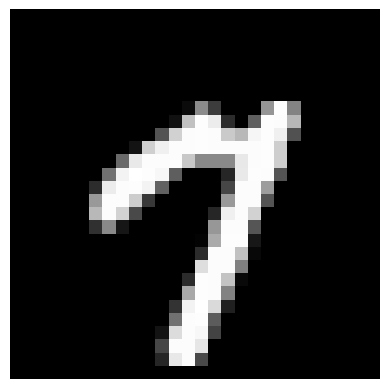

Predicted label: tensor(0)
Actual label: tensor(7)
Probabilities:
Class 0: 0.3087839186191559
Class 1: 0.14620450139045715
Class 2: 0.11649982631206512
Class 3: 0.05082470923662186
Class 4: 0.07270834594964981
Class 5: 0.06579183787107468
Class 6: 0.03944515436887741
Class 7: 0.0498688705265522
Class 8: 0.05469215661287308
Class 9: 0.0951806828379631



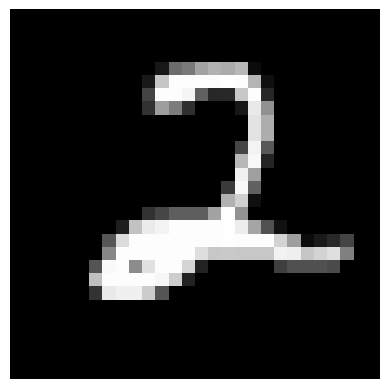

Predicted label: tensor(0)
Actual label: tensor(2)
Probabilities:
Class 0: 0.31103241443634033
Class 1: 0.14460352063179016
Class 2: 0.11797168105840683
Class 3: 0.053396813571453094
Class 4: 0.07198859006166458
Class 5: 0.06417770683765411
Class 6: 0.039095330983400345
Class 7: 0.048574890941381454
Class 8: 0.054786089807748795
Class 9: 0.09437301009893417



In [46]:
# Only 3 images are selected
images = images[:3]
labels = labels[:3]

p_yx = model(images)

# Get predicted probabilities
probabilities = F.softmax(p_yx, dim=1)

# Find predicted labels
predicted_labels = probabilities.argmax(dim=1)

# Compare predicted labels with actual labels and display the images
for i in range(len(images)):
    # Convert the image tensor to a numpy array
    image = images[i].squeeze().numpy()

    # Display the image in grayscale
    plt.imshow(image, cmap='gray')
    plt.axis('off')
    plt.show()

    print("Predicted label:", predicted_labels[i])
    print("Actual label:", labels[i])
    print("Probabilities:")

    # Print probabilities for each class
    for j in range(len(probabilities[i])):
        class_name = f"Class {j}"
        probability = probabilities[i][j].item()
        print(f"{class_name}: {probability}")

    print()